In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()

### **Import Training and Testing set**

*We will use SMOTE balanced dataset for the purpose of tunning the hyperparameters* 

In [2]:
train_smote = pd.read_pickle("data/train_smote.pickle")
test = pd.read_pickle("data/test.pickle")

### **Split Attributes and Target Class**

In [3]:
x = train_smote.iloc[:, :-1]
y = train_smote["Class"]

### **Split training and validation set**

In [4]:
from sklearn.model_selection import train_test_split
xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, test_size=0.25, stratify=y,random_state=123)

### **Xgboost**

*Xgboost stands for `Extreme Gradient Boosting`. Xgboost is highly scalable and uses distributed 
gradient boosted decision trees for fitting the data*

In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

### **Tunning Hyperparameters**

*We need to tune parameters to gain maximum accuracy for classification. We will use optuna framework to tune
our parameters. Parameters that needed to be tuned include*
1. n_estimators
2. subsample
3. lambda
4. gamma

In [6]:
def optimize(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "n_estimators": trial.suggest_int("n_estimators", 200, 500),
        "subsample":trial.suggest_float("subsample", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 0.01, 1.0),
        "gamma": trial.suggest_float("gamma", 0.01, 10.0),
        "n_jobs": -1
    }
    xgb = XGBClassifier(**params, use_label_encoder=False)
    xgb.fit(xtrain, ytrain)
    ypred = xgb.predict(xvalid)
    auc = roc_auc_score(yvalid, ypred)
    return auc

In [7]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(optimize,n_trials=20 )

[I 2022-08-21 18:31:02,454] A new study created in memory with name: no-name-0c785ee3-133a-4b93-90f0-1352a3688e67
[I 2022-08-21 18:32:02,604] Trial 0 finished with value: 0.9997405095384468 and parameters: {'n_estimators': 230, 'subsample': 0.6164480175191673, 'lambda': 0.3041742179829454, 'gamma': 2.1314377554506563}. Best is trial 0 with value: 0.9997405095384468.
[I 2022-08-21 18:34:44,141] Trial 1 finished with value: 0.9996154530676258 and parameters: {'n_estimators': 488, 'subsample': 0.7079435658931488, 'lambda': 0.6939114464563968, 'gamma': 9.865239829458273}. Best is trial 0 with value: 0.9997405095384468.
[I 2022-08-21 18:37:59,338] Trial 2 finished with value: 0.9995591791512333 and parameters: {'n_estimators': 478, 'subsample': 0.9198617845457258, 'lambda': 0.17596762535633803, 'gamma': 7.497938835169066}. Best is trial 0 with value: 0.9997405095384468.
[I 2022-08-21 18:39:50,308] Trial 3 finished with value: 0.9995716842705 and parameters: {'n_estimators': 288, 'subsample'

### **Fitting model**

*We implement function that fits the data with specific hyperparameters to the Xgboost model and then 
prints the precision recall for target classes in test set with the confusion matrix of validation and 
test set*

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
def xgb_fit(train_set):
    xtrain, xvalid, ytrain, yvalid = train_test_split(train_set.iloc[:,:-1], train_set["Class"], test_size=0.25, random_state=123)
    xgb = XGBClassifier(objective="binary:logistic",
                        eval_metric="auc",
                        n_estimators=200, 
                        subsample=0.70, 
                        eta=0.01, 
                        gamma=0.01, 
                        n_jobs=-1, 
                        use_label_encoder=False)
    xgb.fit(xtrain, ytrain)
    v_pred = xgb.predict(xvalid)
    y_pred = xgb.predict(test.iloc[:,:-1])
    vcm = confusion_matrix(yvalid,v_pred)
    ycm = confusion_matrix(test["Class"], y_pred)
    fig , axes = plt.subplots(1,2)
    fig1 = sns.heatmap(vcm, cmap="Blues", linewidths=0.9, cbar=False, annot=True, fmt ="d",ax=axes[0])
    fig2 = sns.heatmap(ycm, cmap="Blues", linewidths=0.9, cbar=False, annot=True, fmt ="d",ax=axes[1])
    fig1.set(xlabel="Predicted", ylabel="Truth")
    fig1.set_title("Validation")
    fig2.set(xlabel="Predicted", ylabel="Truth")
    fig2.set_title("Test")
    fig.suptitle("XGBoost")
    plt.tight_layout()
    print(classification_report(test["Class"], y_pred))

### **Undersampling**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.52      0.85      0.64       123

    accuracy                           1.00     71202
   macro avg       0.76      0.92      0.82     71202
weighted avg       1.00      1.00      1.00     71202



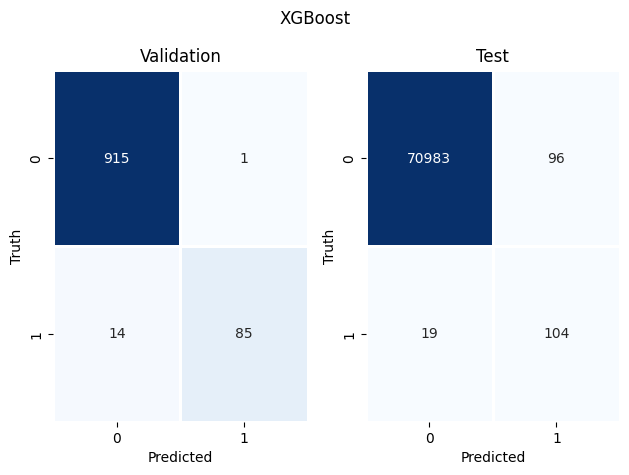

In [14]:
train_under = pd.read_pickle("data/train_under.pickle")
xgb_fit(train_under)

### **Bootstrap Sampling**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.63      0.78      0.70       123

    accuracy                           1.00     71202
   macro avg       0.81      0.89      0.85     71202
weighted avg       1.00      1.00      1.00     71202



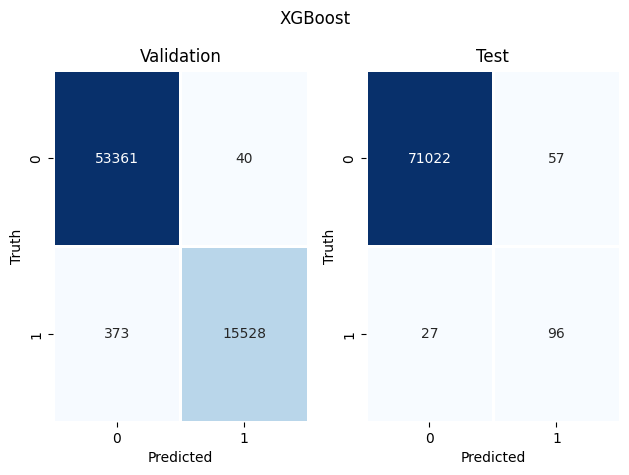

In [15]:
train_over = pd.read_pickle("data/train_over.pickle")
xgb_fit(train_over)

### **Oversampling with shrinkage**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.42      0.84      0.56       123

    accuracy                           1.00     71202
   macro avg       0.71      0.92      0.78     71202
weighted avg       1.00      1.00      1.00     71202



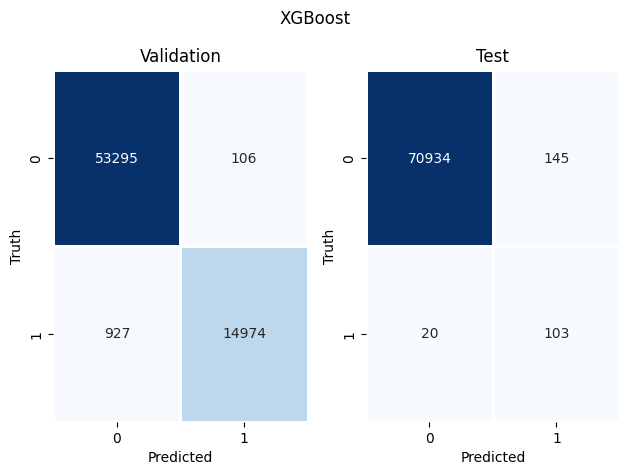

In [16]:
train_over_shrink = pd.read_pickle("data/train_over_shrink.pickle")
xgb_fit(train_over_shrink)

### **SMOTE**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.46      0.80      0.59       123

    accuracy                           1.00     71202
   macro avg       0.73      0.90      0.79     71202
weighted avg       1.00      1.00      1.00     71202



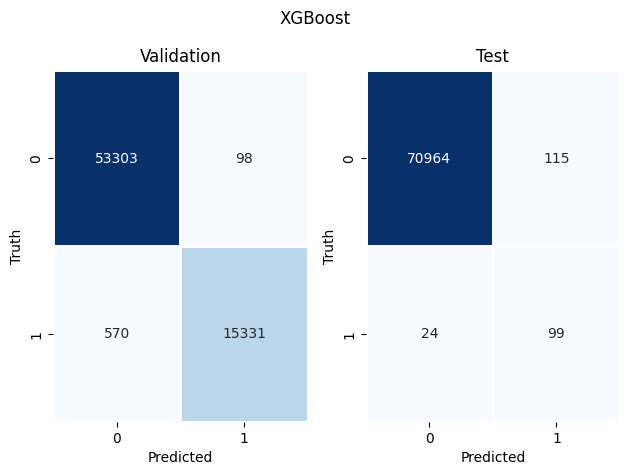

In [17]:
xgb_fit(train_smote)

### **ADASYN**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.42      0.80      0.56       123

    accuracy                           1.00     71202
   macro avg       0.71      0.90      0.78     71202
weighted avg       1.00      1.00      1.00     71202



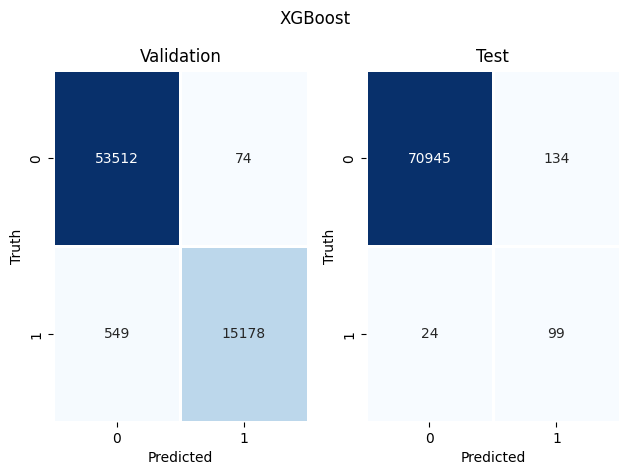

In [18]:
train_adasyn = pd.read_pickle("data/train_adasyn.pickle")
xgb_fit(train_adasyn)

### **Save Model**

In [19]:
xtrain = train_over_shrink.iloc[:, :-1].to_numpy()
ytrain = train_over_shrink["Class"].to_numpy()
xgb = XGBClassifier(objective="binary:logistic",
                        eval_metric="auc",
                        n_estimators=200, 
                        subsample=0.70, 
                        eta=0.01, 
                        gamma=0.01, 
                        n_jobs=-1, 
                        use_label_encoder=False)
xgb.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.01, eval_metric='auc', gamma=0.01, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [20]:
import joblib
joblib.dump(xgb, "models/xgb.pkl")

['models/xgb.pkl']